# Fake News Classifier

## About Dataset

(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

There are 78098 data entries in csv file out of which only 72134 entries are accessed as per the data frame.

Published in:
IEEE Transactions on Computational Social Systems: pp. 1-13 (doi: 10.1109/TCSS.2021.3068519).

## Main Objective

The main objective of this notebook is to classify news articles based on their title and content as fake news or not fake news.

In [1]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [27]:
import kagglehub
import kagglehub
import shutil
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cjr21\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cjr21\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Download latest version
path = kagglehub.dataset_download("saurabhshahane/fake-news-classification")

destination = r"data"
for item in os.listdir(path):
    src = os.path.join(path, item)
    dest = os.path.join(destination, item)
    if os.path.isdir(src):
        shutil.copytree(src, dest, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dest)

## Exploratory Data Analysis

In [4]:
df = pd.read_csv(r"data\WELFake_Dataset.csv", index_col=0)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
df.shape

(72134, 3)

In [6]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

There are 35,028 real and 37,106 fake news articles in the dataset.

Text(0, 0.5, 'Count')

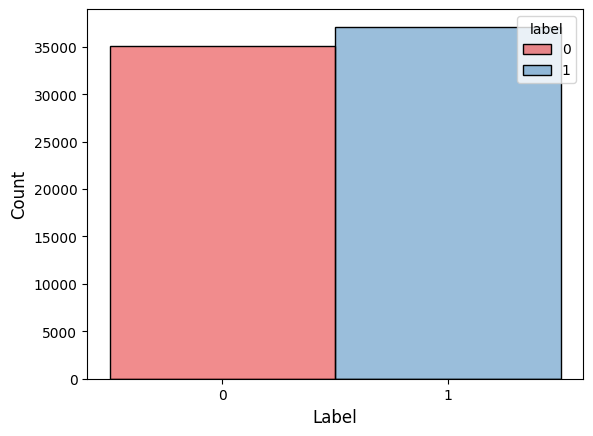

In [ ]:
sns.histplot(data=df, x="label", bins=2, palette="Set1", hue="label", discrete=True)
plt.xticks([0, 1], ["0", "1"])
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)

The majority of the titles have between 5 and 20 tokens. The distribution of the fake titles looks a lot smoother than the real titles.

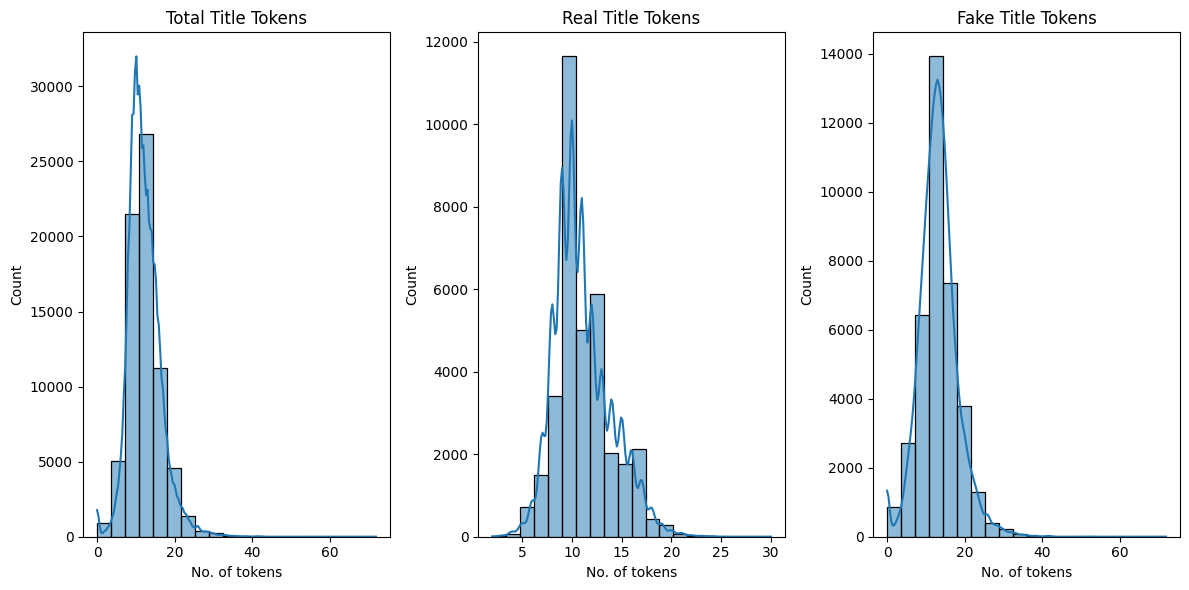

In [93]:
title_tokens = df["title"].apply(lambda x:len(x.split()))
fig,(ax1,ax2, ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(df["title"].apply(lambda x:len(x.split())),ax=ax1,bins=20, kde=True)
ax1.set_xlabel('No. of tokens')
ax1.set_title("Total Title Tokens")

ax2 = sns.histplot(df[df["label"]==0]["title"].apply(lambda x:len(x.split())),ax=ax2,bins=20, kde=True)
ax2.set_xlabel('No. of tokens')
ax2.set_title("Real Title Tokens")

ax3 = sns.histplot(df[df["label"]==1]["title"].apply(lambda x:len(x.split())),ax=ax3,bins=20, kde=True)
ax3.set_xlabel('No. of tokens')
ax3.set_title("Fake Title Tokens")

plt.tight_layout()

There are much fewer words in the Fake text than in the Real text.

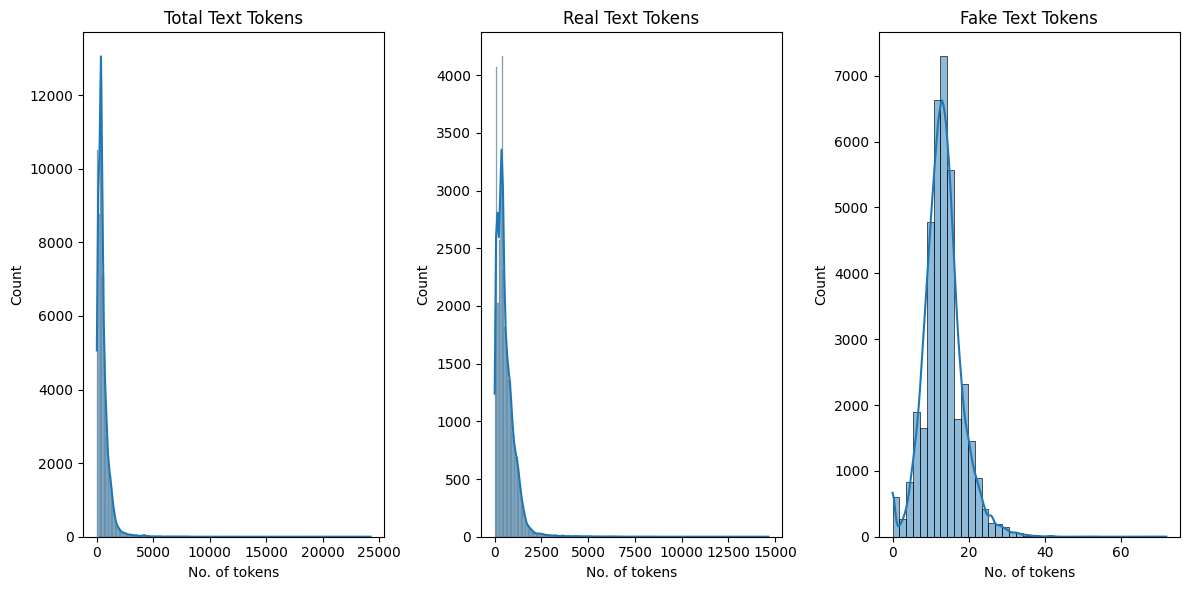

In [95]:
title_tokens = df["text"].apply(lambda x:len(x.split()))
fig,(ax1,ax2, ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(df["text"].apply(lambda x:len(x.split())),ax=ax1,bins=200, kde=True)
ax1.set_xlabel('No. of tokens')
ax1.set_title("Total Text Tokens")

ax2 = sns.histplot(df[df["label"]==0]["text"].apply(lambda x:len(x.split())),ax=ax2,bins=200, kde=True)
ax2.set_xlabel('No. of tokens')
ax2.set_title("Real Text Tokens")

ax3 = sns.histplot(df[df["label"]==1]["title"].apply(lambda x:len(x.split())),ax=ax3,bins=40, kde=True)
ax3.set_xlabel('No. of tokens')
ax3.set_title("Fake Text Tokens")

plt.tight_layout()

## Data Processing

Combine title and text into a new column to be used for classification.

In [8]:
df["title"] = df["title"].fillna(" ")
df["text"] = df["text"].fillna(" ")
df["combined_text"] = df["title"] + " " + df["text"]
df.head()

,title,text,label,combined_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...


### Stop words

Stop words like "the", "and", and "I", although common, don"t usually provide meaningful information about a document’s specific topic. By eliminating these words from a corpus, we can more easily identify unique and relevant terms.

The stop words will be removed but negative words like "not" and "no" will be left in.


In [9]:
stop_words = set(stopwords.words("english"))
stop_words.discard("not")
stop_words.discard("no")

### Lemmatization

Lemmatization is a process that reduces a word to its root form, or lemma, by removing inflectional endings. Lemmatization groups together inflected forms of a word. For example, "runs," "running," and "ran" would all be lemmatized to "run". Lemmatization helps identify similarities between words by reducing them to their root meaning which reduces dimensionality in the dataset.

In [68]:
lem = WordNetLemmatizer()
corpus = []

for i in range(len(df)):
    review = re.sub("^a-zA-Z0-9", " ", df["combined_text"][i])
    review = review.lower()
    review = review.split()
    review = [lem.lemmatize(x) for x in review if x not in stop_words]
    review = " ".join(review)
    corpus.append(review)

In [ ]:
#Combine corpus and label to show word counts of fake and real news



from collections import Counter
real_words = []
for row in df[df["label"]==0]["text"]:
    for word in row.split():
        if word.lower() not in stop_words:
            real_words.append(word)
counter = Counter(real_words)
counter.most_common(10)

['law enforcement high alert following threat cop white 9-11by #blacklivesmatter #fyf911 terrorist [video] no comment expected barack obama member #fyf911 #fukyoflag #blacklivesmatter movement called lynching hanging white people cops. encouraged others radio show tuesday night turn tide kill white people cop send message killing black people america.one f***yoflag organizer called sunshine. radio blog show hosted texas called, sunshine f***ing opinion radio show. snapshot #fyf911 @lolatwhitefear twitter page 9:53 p.m. show urging supporter call now!! #fyf911 tonight continue dismantle illusion white snapshot twitter radio call invite #fyf911the radio show aired 10:00 p.m. eastern standard time.during show, caller clearly call lynching killing white people.a 2:39 minute clip radio show heard here. provided breitbart texas someone would like referred hannibal. already received death threat result interrupting #fyf911 conference calls.an unidentified black man said mother f**kers themsel

### Vectorization with TF-IDF

The Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer is a widely used technique in text processing that reflect the importance of words in a document relative to a collection of documents or corpus. The TF-IDF method weighs a term’s frequency and its inverse document frequency, producing a numerical statistic that reflect how important a word is to a document in a collection.

In [11]:
tf = TfidfVectorizer()
X = tf.fit_transform(corpus)

In [12]:
y = df["label"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

## Models

### Random Forest Classifier

A Random Forest Classifier with default parameters will be used to classify fake and not-fake news.

In [14]:
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [20]:
rf_pred = rf_model.predict(X_test)
rf_score = accuracy_score(y_test, rf_pred)
rf_score

0.9368328635460469

### Gradient Boosting Classifier

A Gradient Boosting Classifier with default parameters will be used to classify fake and not-fake news.

In [16]:
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [21]:
gbc_pred = gbc_model.predict(X_test)
gbc_score = accuracy_score(y_test, gbc_pred)
gbc_score

0.9445959059193199

### Support Vector Machine

A Support Vector Machine Classifier with default parameters will be used to classify fake and not-fake news.

In [18]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [19]:
svc_pred = svc_model.predict(X_test)
svc_score = accuracy_score(y_test, svc_pred)
svc_score

0.966544984058038

## Evaluation

A confusion matrix and classification report will be used to evaluate each model.

### Random Forest

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

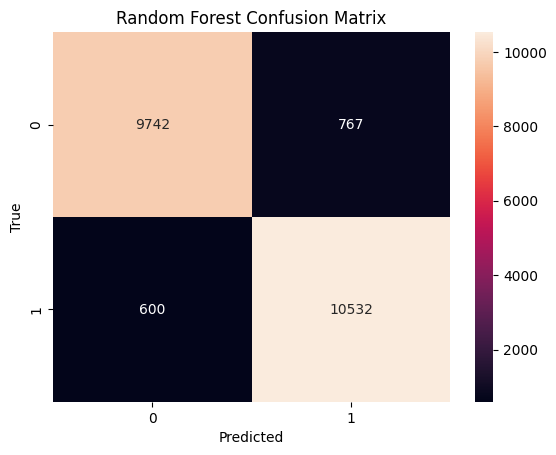

In [ ]:
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")

In [32]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10509
           1       0.93      0.95      0.94     11132

    accuracy                           0.94     21641
   macro avg       0.94      0.94      0.94     21641
weighted avg       0.94      0.94      0.94     21641



### Gradient Boosting Classifier

Text(0.5, 1.0, 'Gradient Boosting Confusion Matrix')

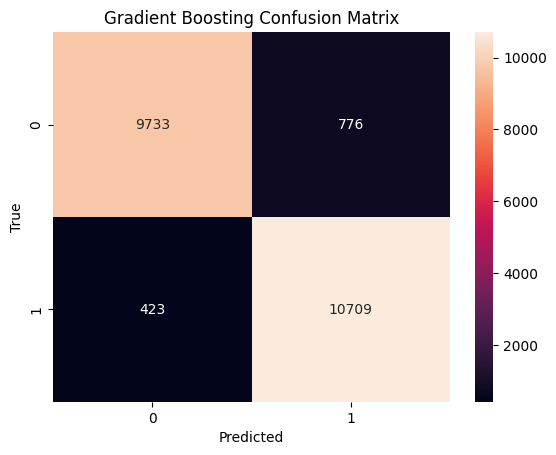

In [33]:
gbc_cm = confusion_matrix(y_test, gbc_pred)
sns.heatmap(gbc_cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gradient Boosting Confusion Matrix")

In [35]:
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     10509
           1       0.93      0.96      0.95     11132

    accuracy                           0.94     21641
   macro avg       0.95      0.94      0.94     21641
weighted avg       0.95      0.94      0.94     21641



### Support Vector Machine Classifier

In [36]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10509
           1       0.96      0.98      0.97     11132

    accuracy                           0.97     21641
   macro avg       0.97      0.97      0.97     21641
weighted avg       0.97      0.97      0.97     21641



### Conclusion

The Support Vector Machine Classifier has the best f1-score, precision and recall of class 0, and precision and recall of class 1. Based on this analysis the Support Vector Machine Classifier is the best model.

All three models did very well in detecting fake news using tf-idf and lemmitization. Additional analysis could be done by using PorterStemmer instead of lemmitization as well as using a grid search to find the best parameters for each model.

### Follow Up

Additional processing of the data should be investigated to improve the quality of the input to the NLP algorithms. The data should also be split into a test and validation set. Each model should be trained on the training data and evaluated based using the test data. When the best model is selected it should be tested against the validation set. Each model shows high accuracy and this additional validation could help confirm the model is not overfitting.